In [66]:
from pathlib import Path
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
os.chdir('/home/weedsci/matt/SemiF-AnnotationPipeline')
from semif_utils.utils import get_cutout_meta

In [217]:
# Get all json files
path = "data/semifield-cutouts/NC_2022-07-14.csv"
df = pd.read_csv(path)
df["is_green"] = np.where(df.is_green==True, 1, 0).astype(float)
df["is_primary"] = np.where(df.is_primary==True, 1, 0).astype(float)
df["extends_border"] = np.where(df.extends_border==True, 1, 0).astype(float)
df["green_sum"] = df.green_sum.astype(float)
df.columns

ncols = [
       # 'is_primary', 'extends_border', 'is_green',
       'area', 'common_name',
       # 'collection_location',
       'area_bbox', 'area_convex',
       # 'axis_major_length', 'axis_minor_length', 'centroid0', 'centroid1',
       'eccentricity', 'solidity', 'perimeter', 'green_sum']
trn = [
       'area',
       # 'axis_major_length', 'axis_minor_length', 'centroid0', 'centroid1',
       'eccentricity', 'solidity', 
       'perimeter', 
       'green_sum']

specdf = df[df["common_name"] == "Soybean"]
specdf.head()

,index,blob_home,data_root,batch_id,image_id,cutout_num,datetime,cutout_id,cutout_path,is_primary,...,area_convex,axis_major_length,axis_minor_length,centroid0,centroid1,eccentricity,solidity,perimeter,is_green,green_sum
3,0,data,semifield-cutouts,NC_2022-07-14,NC_1657826808,3,2022:07:14 15:25:42,NC_1657826808_3,NC_2022-07-14/NC_1657826808_3.png,0.0,...,118365.0,569.006020,303.099077,216.097731,355.847596,0.846316,0.893161,1858.555483,1.0,99255.0
9,0,data,semifield-cutouts,NC_2022-07-14,NC_1657826563,13,2022:07:14 15:21:36,NC_1657826563_13,NC_2022-07-14/NC_1657826563_13.png,0.0,...,328350.0,708.386370,561.834289,324.260332,319.497662,0.609067,0.677235,3568.713129,1.0,206331.0
29,0,data,semifield-cutouts,NC_2022-07-14,NC_1657826900,9,2022:07:14 15:27:13,NC_1657826900_9,NC_2022-07-14/NC_1657826900_9.png,0.0,...,374999.0,876.804003,529.106786,311.745229,484.325461,0.797401,0.754018,4445.496967,1.0,254323.0
31,0,data,semifield-cutouts,NC_2022-07-14,NC_1657826186,11,2022:07:14 15:15:20,NC_1657826186_11,NC_2022-07-14/NC_1657826186_11.png,0.0,...,89461.0,383.424638,288.691734,178.396430,200.252256,0.658101,0.683829,2286.885569,1.0,48136.0
44,0,data,semifield-cutouts,NC_2022-07-14,NC_1657826083,4,2022:07:14 15:13:36,NC_1657826083_4,NC_2022-07-14/NC_1657826083_4.png,1.0,...,18876.0,233.407242,108.136970,139.505642,84.499547,0.886203,0.643198,839.542243,1.0,4357.0


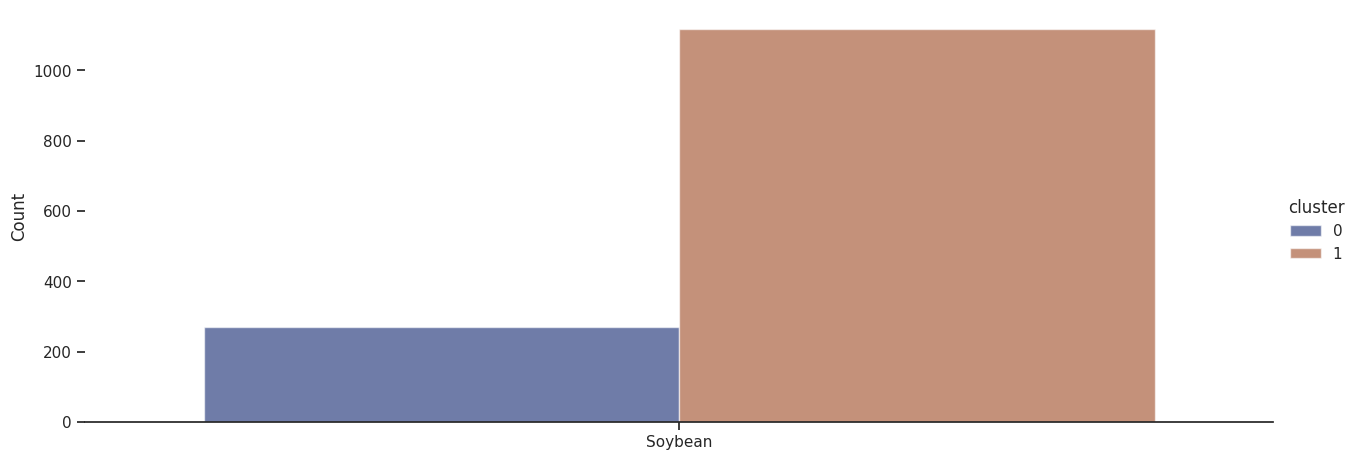

In [218]:
import sklearn.cluster as cl
from sklearn.preprocessing import StandardScaler
sns.set_theme(style="ticks")

specdf = df[df["common_name"] == "Soybean"]
trndf = specdf[trn].values.astype(float)
trn_arr = StandardScaler().fit_transform(trndf)
cls = cl.KMeans(n_clusters=2, random_state=42).fit(trn_arr)
# if hasattr(cls, "labels_"):
    # labels = cls.labels_.astype(int)
labels = cls.labels_
res = pd.DataFrame(data=labels, columns=["cluster"], index=specdf.index)
res["common_name"] = specdf["common_name"]
df["cluster"] = res["cluster"]
g = sns.catplot(data=res, kind="count", x="common_name", hue="cluster", palette="dark", alpha=.6, aspect=2.6)
g.despine(left=True)
g.set_axis_labels("","Count")



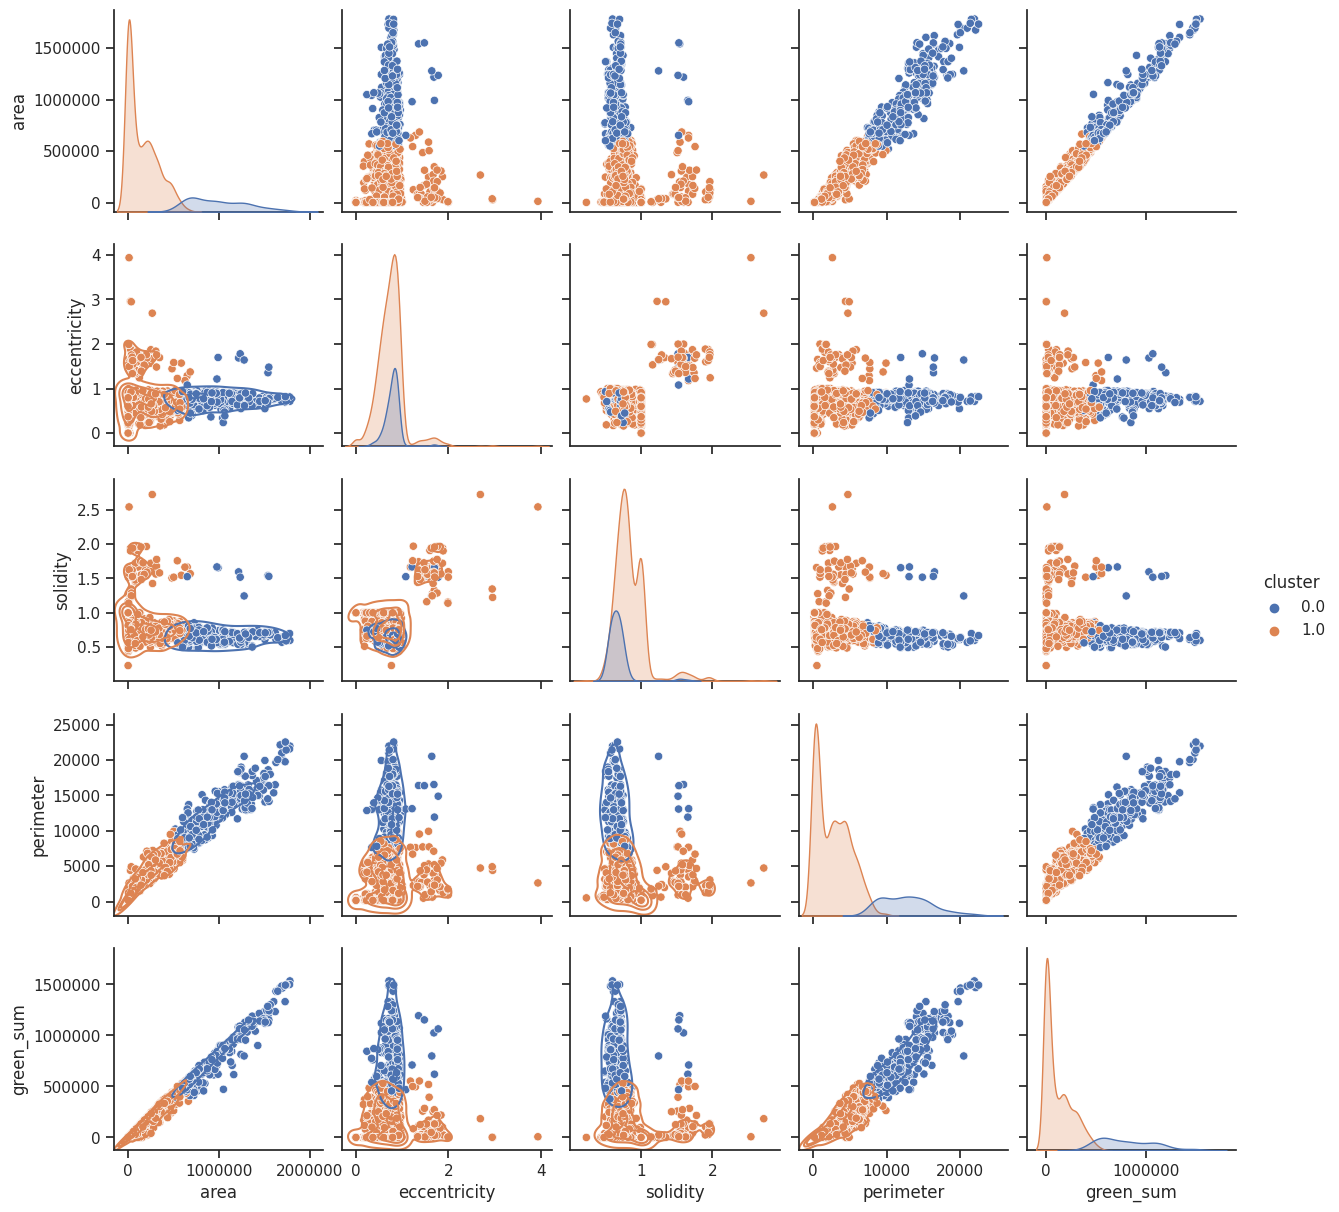

In [181]:
clst_trn = [
            'area',
            'cluster',
            'eccentricity',
            'solidity', 
            'perimeter', 
            'green_sum',
            'common_name'
            ]
prplot_data = df[df["common_name"]=="Soybean"][clst_trn]
g = sns.pairplot(data=prplot_data,hue="cluster", diag_kind="kde").map_lower(sns.kdeplot, levels=4, color=".2")
# ax.ticklabel_format(style='plain', axis='both')
for ax in g.axes.flatten():
    ax.ticklabel_format(style='plain', axis='both')

In [ ]:
variables = ["body_mass_g", "bill_length_mm", "flipper_length_mm"]
g = sns.PairGrid(prplot_data, hue="body_mass_g", vars=variables)
g.map_diag(sns.histplot, hue=None, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()

1193345.0
1549697.0
67


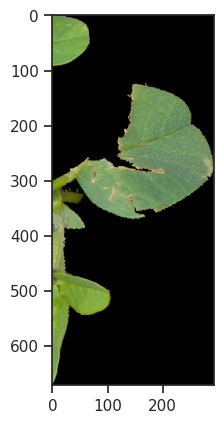

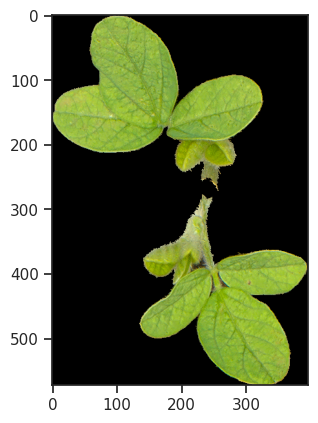

In [184]:
anlyz = df[df["common_name"]=="Soybean"]
# anlyz = anlyz[anlyz["cluster"]==0]
# anlyz = anlyz[anlyz["eccentricity"]<1]
anlyz = anlyz[anlyz["eccentricity"]>1]
anlyz = anlyz[anlyz["solidity"]>1]
# print((anlyz["green_sum"]).max())
# print((anlyz["area"]).max())
anlyz["path"] = anlyz["blob_home"] + "/" + anlyz["data_root"] + "/" + anlyz["cutout_path"]

src = anlyz["path"]
samp = src.sample(n=2)
for sam in samp:
    img = cv2.cvtColor(cv2.imread(sam), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

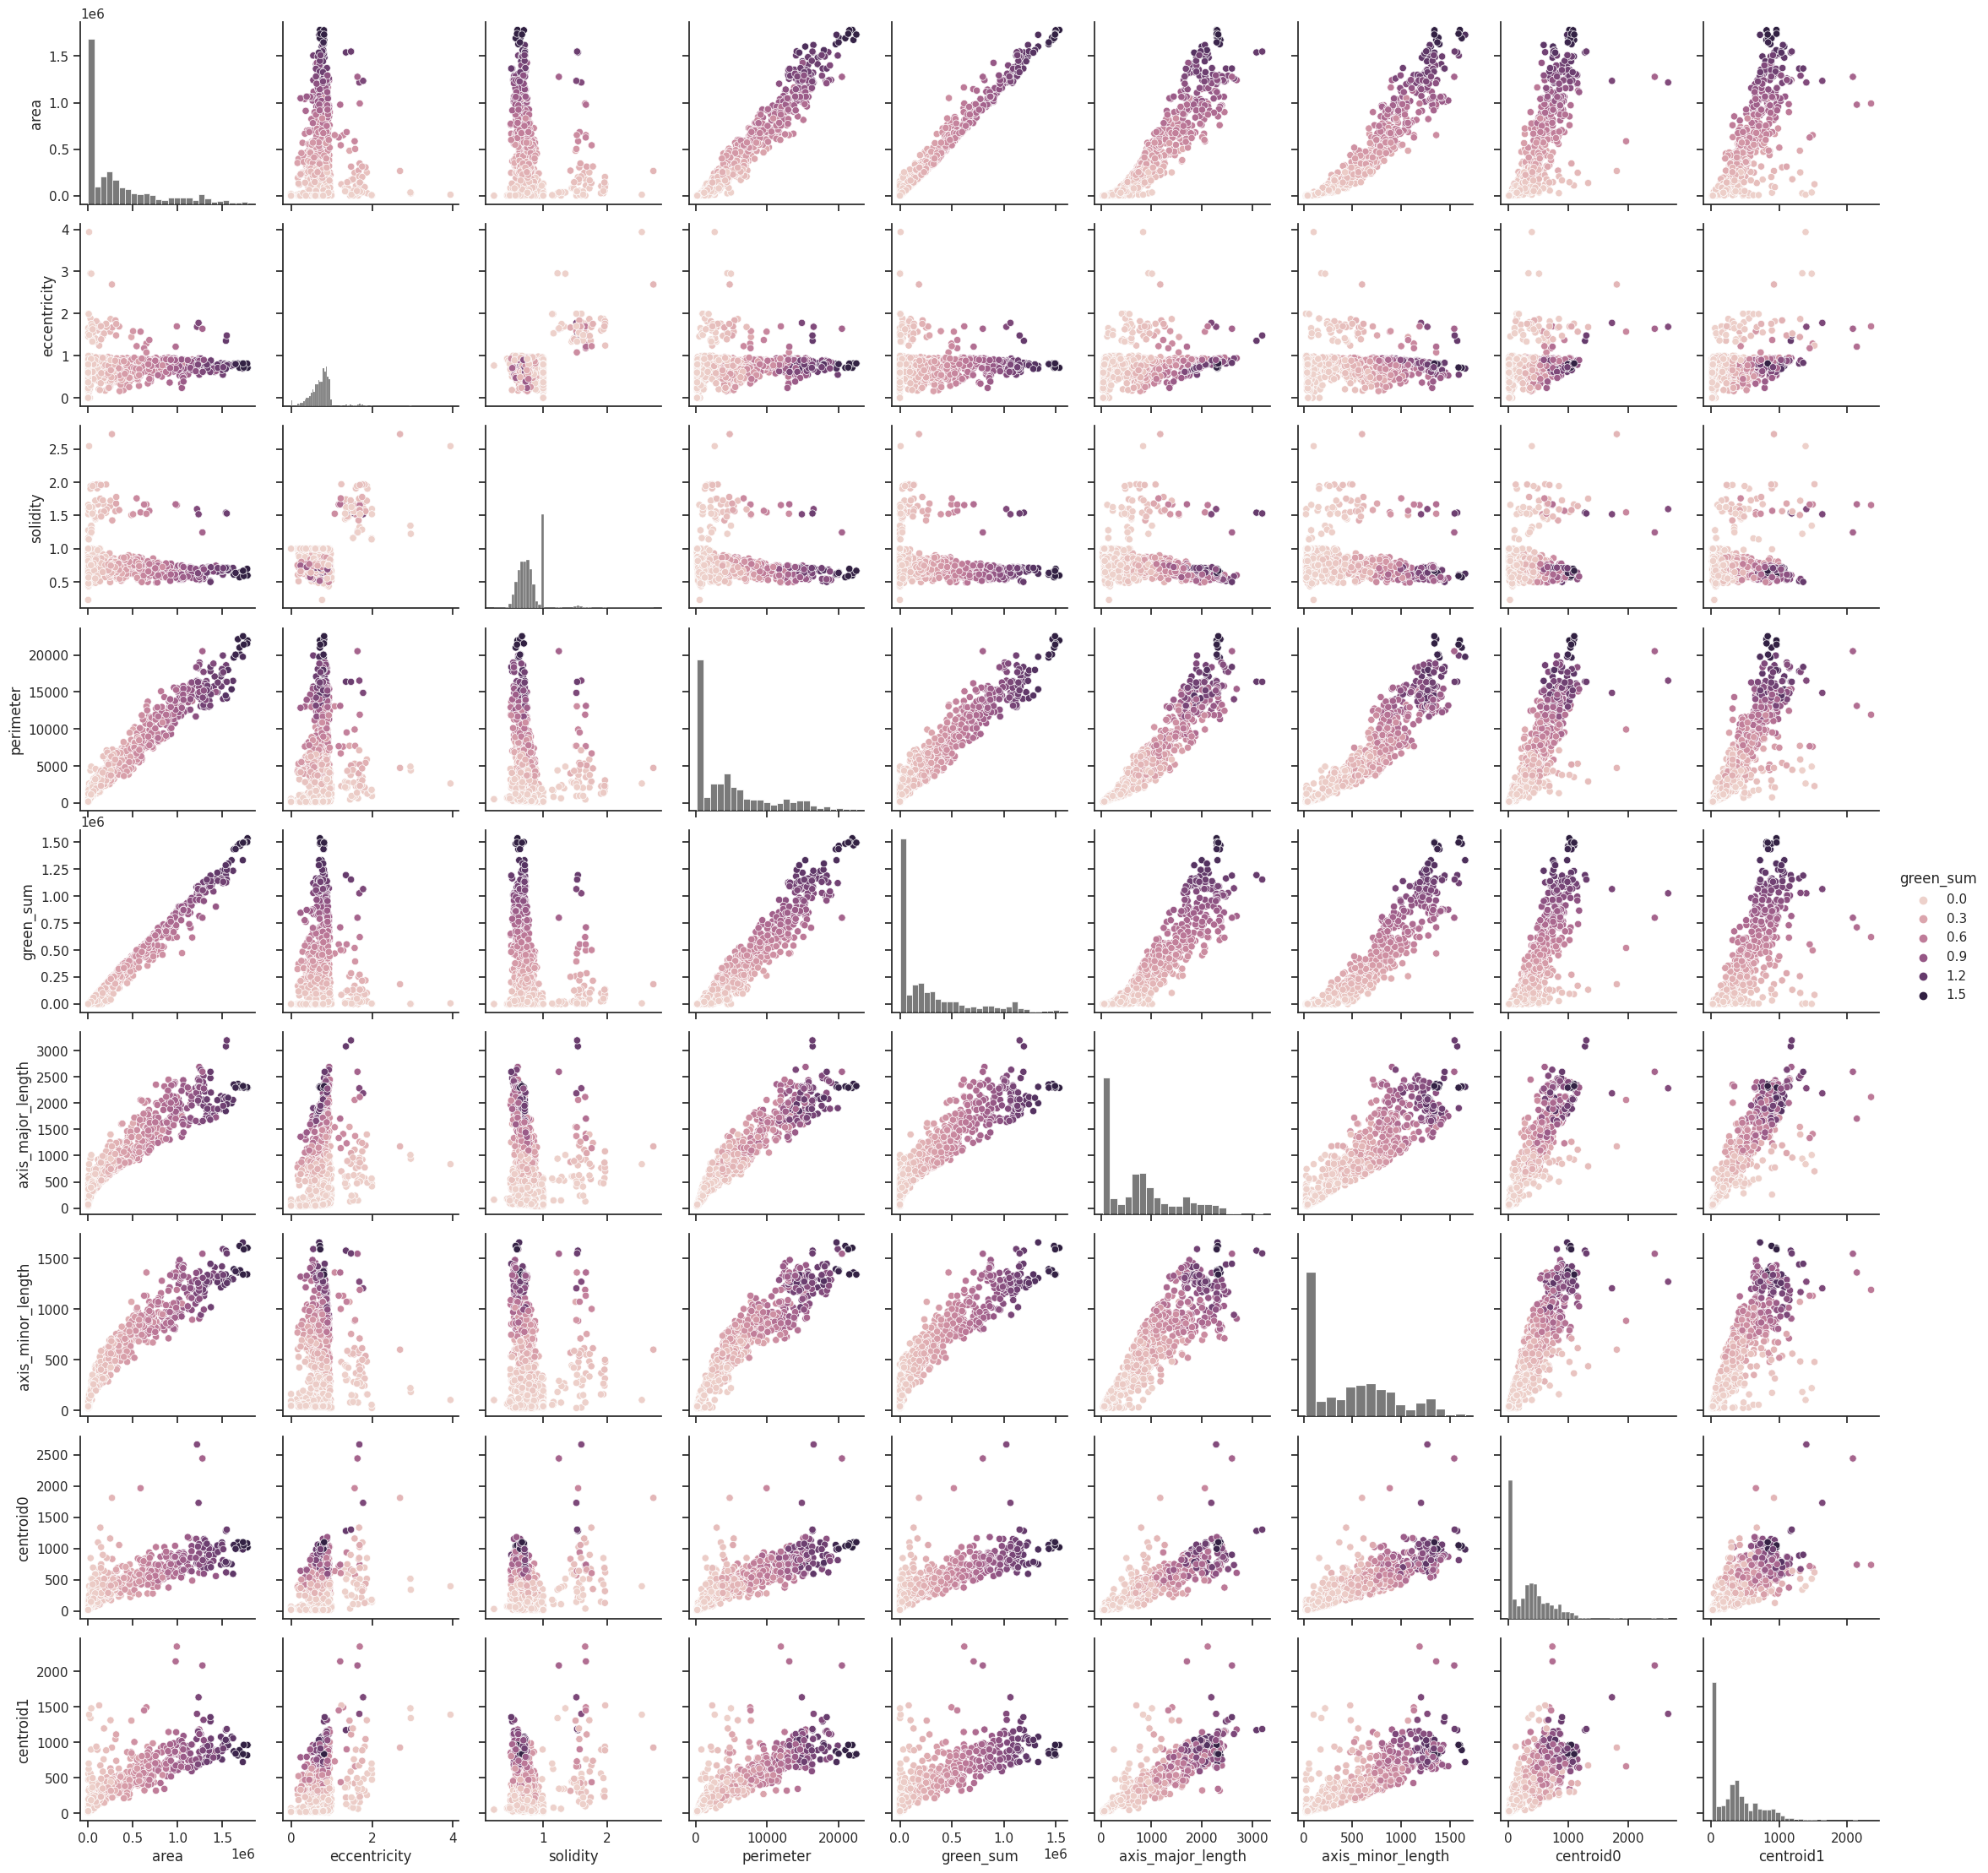

In [222]:
spec = df[df["common_name"]=="Soybean"]
high_green = spec[spec["green_sum"]>100000]
low_green = spec[spec["green_sum"]<2000]
high_area = spec[spec["area"]>1000000]
low_area = spec[spec["area"]<5000]

concat_list = [high_green, low_green, high_area, low_area, spec]
extemes = pd.concat(concat_list).reset_index()


clst_trn = [
            'area',
            'eccentricity',
            'solidity', 
            'perimeter', 
            'green_sum',
            # 'common_name',
            'axis_major_length', 
            'axis_minor_length', 
            'centroid0', 
            'centroid1'
            ]

g = sns.PairGrid(extemes, hue="green_sum", vars=clst_trn)
g.map_diag(sns.histplot, hue=None, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()
# for ax in g.axes.flatten():
    # ax.ticklabel_format(style='plain', axis='both')

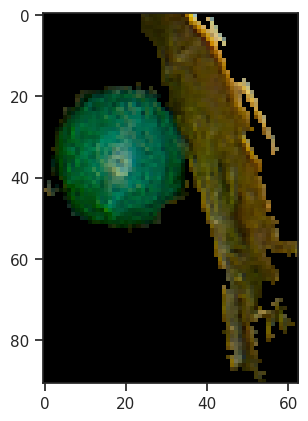

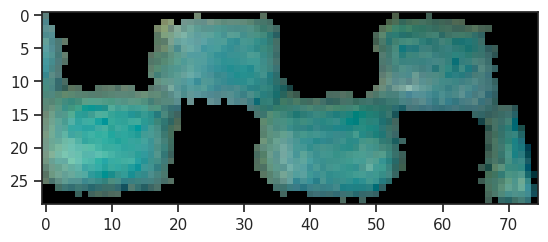

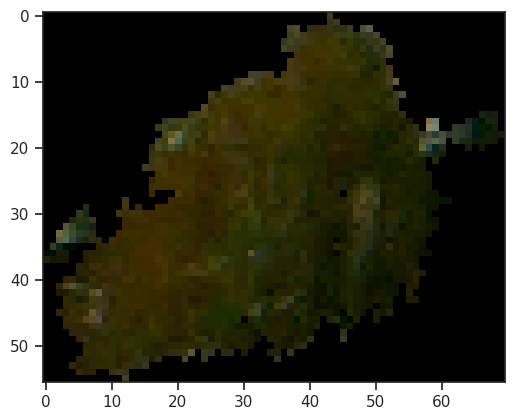

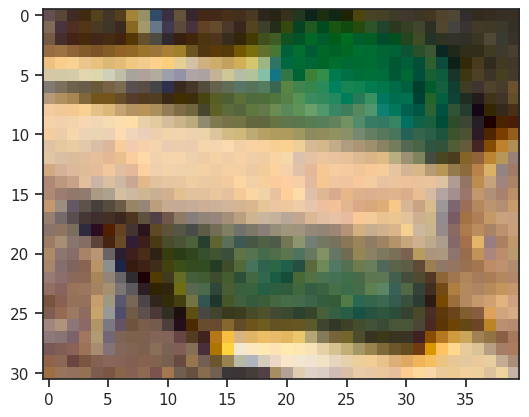

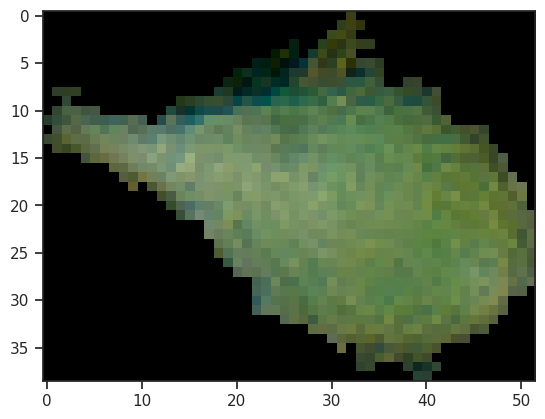

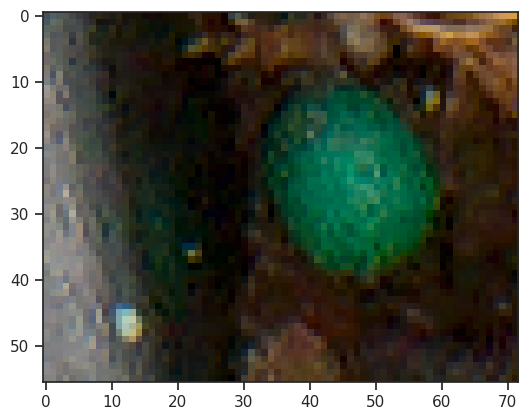

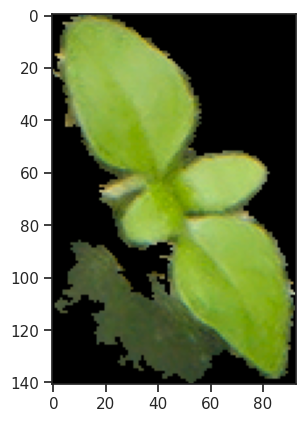

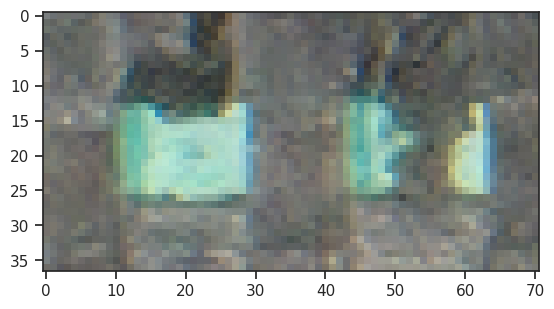

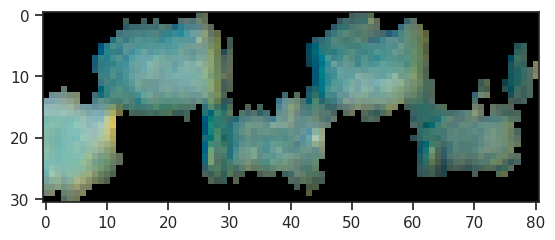

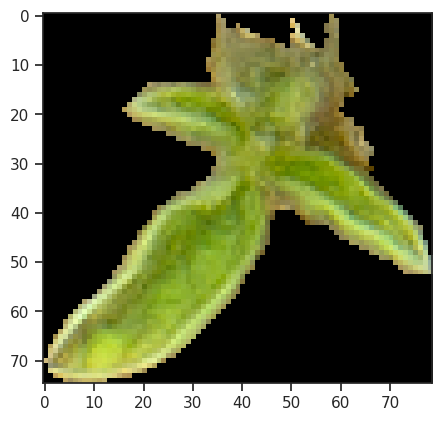

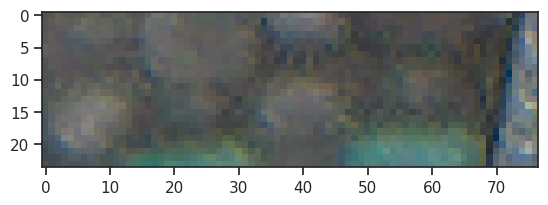

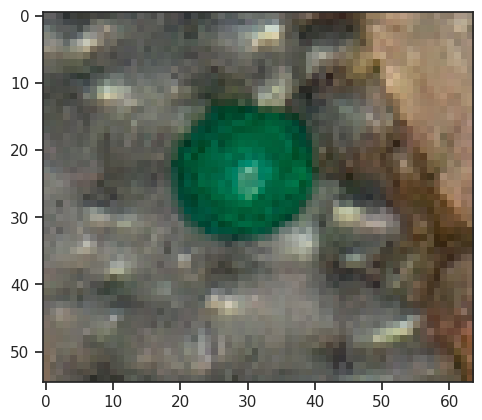

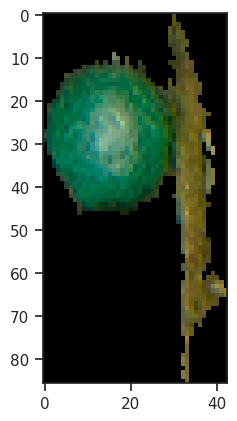

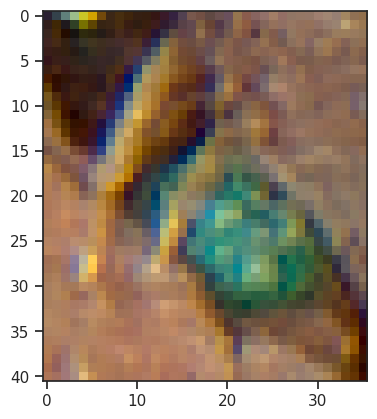

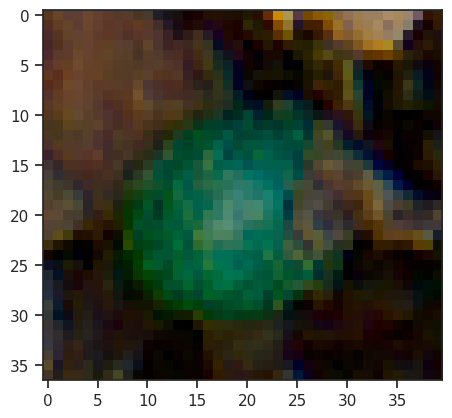

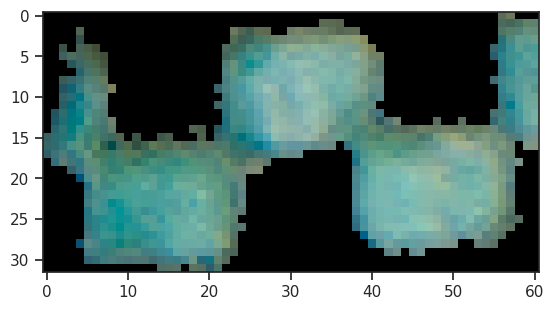

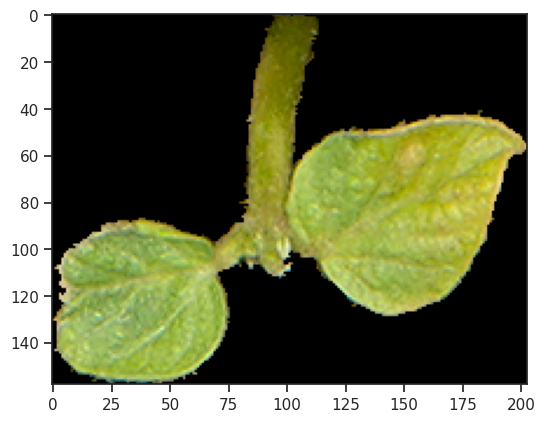

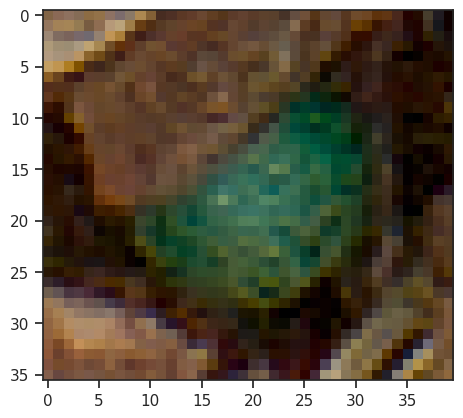

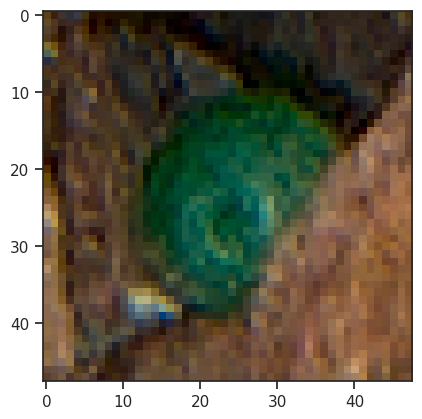

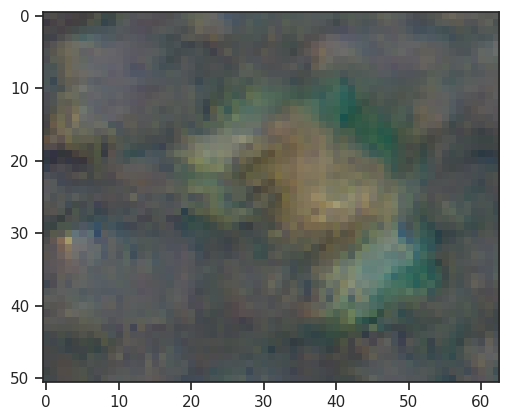

In [225]:
anlyz = df[df["common_name"]=="Soybean"]
# anlyz = anlyz[anlyz["cluster"]==0]
# anlyz = anlyz[anlyz["eccentricity"]<1]
anlyz = anlyz[anlyz["axis_major_length"]<1200]
anlyz = anlyz[anlyz["axis_minor_length"]<750]
anlyz = anlyz[anlyz["green_sum"]<5000]

# print((anlyz["green_sum"]).max())
# print((anlyz["area"]).max())
anlyz["path"] = anlyz["blob_home"] + "/" + anlyz["data_root"] + "/" + anlyz["cutout_path"]
# print(len(anlyz))
src = anlyz["path"]
samp = src.sample(n=20)
for sam in samp:
    img = cv2.cvtColor(cv2.imread(sam), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()